# Harmonizing data located within and outside of the NASA Earthdata Cloud

---

## Timing

- Exercise: 45 min
-
-


---

## Summary

This tutorial will combine several workflow steps and components from the previous days, demonstrating the process of using the geolocation of data available outside of the Earthdata Cloud to then access coincident variables of cloud-accessible data. This may be a common use case as NASA Earthdata continues to migrate to the cloud, producing a "hybrid" data archive across Amazon Web Services (AWS) and original on-premise data storage systems. Additionally, you may also want to combine field measurements with remote sensing data available on the Earthdata Cloud.

This specific example explores the harmonization of the ICESat-2 ATL03 data product, currently (as of November 2021) available publicaly via direct download at the NSIDC DAAC, with Sea Surface Temperature variables available from PO.DAAC on the Earthdata Cloud. 


### Objectives




---

### Import packages

In [40]:
import requests
import netrc
from pprint import pprint
import os
from pathlib import Path

import s3fs

import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# packages below here are not used
#from xml.etree import ElementTree as ET
#import time
#import zipfile
#import io
#import shutil
#import json
#from urllib import request

### Determine storage location of datasets of interest

First, let's see whether our datasets of interest reside in the Earthdata Cloud or whether they reside on premise, or "on prem" at a local data center.

Background from CMR API (consider removing):
The cloud_hosted parameter can be set to “true” or “false”. When true, the results will be restricted to collections that have a DirectDistributionInformation element or have been tagged with gov.nasa.earthdatacloud.s3.
curl “https://cmr.earthdata.nasa.gov/search/collections?cloud_hosted=true”

### Declare datasets of interest

Identify the dataset ID that is used internally within CMR to designate each dataset

In [3]:
modis_name = 'MODIS_T-JPL-L2P-v2019.0'

icesat2_name = 'ATL03'
# icesat2_id = 'C1997321091-NSIDC_ECS'

In [4]:
CMR_OPS = 'https://cmr.earthdata.nasa.gov/search'
url = f'{CMR_OPS}/{"collections"}'

response = requests.get(url, 
                        params={
                            'short_name': modis_name,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
collections = response.json()['feed']['entry']
for collection in collections:
    print(f'{collection["id"]} {"version:"}{collection["version_id"]}')

C1940475563-POCLOUD version:2019.0
C1693233387-PODAAC version:2019.0


Start with the MODIS dataset, setting the `cloud_hosted` parameter to True:

In [5]:
response = requests.get(url, 
                        params={
                            'concept_id': 'C1940475563-POCLOUD',
                            'cloud_hosted': 'True',
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
print(response.status_code)
print(response.headers['CMR-Hits'])
collections = response.json()['feed']['entry']
pprint(collections)

200
1
[{'archive_center': 'NASA/JPL/PODAAC',
  'associations': {'services': ['S1962070864-POCLOUD', 'S2004184019-POCLOUD'],
                   'tools': ['TL2108419875-POCLOUD', 'TL2092786348-POCLOUD'],
                   'variables': ['V1997811750-POCLOUD',
                                 'V1997811794-POCLOUD',
                                 'V2112014697-POCLOUD',
                                 'V1997811877-POCLOUD',
                                 'V1997811902-POCLOUD',
                                 'V2028668027-POCLOUD',
                                 'V2028632036-POCLOUD',
                                 'V1997811775-POCLOUD',
                                 'V1997811764-POCLOUD',
                                 'V1997811783-POCLOUD',
                                 'V2112014702-POCLOUD',
                                 'V2028632034-POCLOUD',
                                 'V2112014700-POCLOUD',
                                 'V1997811759-POCLOUD',
              

Now we will try our ICESat-2 dataset to see what id's are returned for a given dataset name.

In [6]:
response = requests.get(url, 
                        params={
                            'short_name': icesat2_name,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
collections = response.json()['feed']['entry']
# pprint(collections)

for collection in collections:
    print(f'{collection["id"]} {"version:"}{collection["version_id"]}')

C1705401930-NSIDC_ECS version:003
C1997321091-NSIDC_ECS version:004


Two separate datasets exist in the CMR. Now let's take each ID, setting the `cloud_hosted` parameter to True, to identify which dataset is cloud-hosted:

In [7]:
CMR_OPS = 'https://cmr.earthdata.nasa.gov/search'
url = f'{CMR_OPS}/{"collections"}'

response = requests.get(url, 
                        params={
                            'concept_id': 'C1997321091-NSIDC_ECS',
                            'cloud_hosted': 'False',
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
print(f'Status code: {response.status_code}')
print(f'Hits: {response.headers["CMR-Hits"]}')
collections = response.json()['feed']['entry']
pprint(collections)

Status code: 200
Hits: 1
[{'archive_center': 'NASA NSIDC DAAC',
  'associations': {'services': ['S1568899363-NSIDC_ECS',
                                'S1613689509-NSIDC_ECS',
                                'S1977894169-NSIDC_ECS',
                                'S2013502342-NSIDC_ECS'],
                   'tools': ['TL1950215144-NSIDC_ECS',
                             'TL1977971361-NSIDC_ECS',
                             'TL1993837300-NSIDC_ECS',
                             'TL1952642907-NSIDC_ECS']},
  'boxes': ['-90 -180 90 180'],
  'browse_flag': False,
  'coordinate_system': 'CARTESIAN',
  'data_center': 'NSIDC_ECS',
  'dataset_id': 'ATLAS/ICESat-2 L2A Global Geolocated Photon Data V004',
  'has_formats': True,
  'has_spatial_subsetting': True,
  'has_temporal_subsetting': True,
  'has_transforms': False,
  'has_variables': True,
  'id': 'C1997321091-NSIDC_ECS',
  'links': [{'href': 'https://n5eil01u.ecs.nsidc.org/ATLAS/ATL03.004/',
             'hreflang': 'en-US',
       

What happens if we comment out this parameter? Do we see results returned? 
[TODO: Add instructions on how to comment lines using command slash]  
__It would make more sense to set `cloud_hosted` to False__

__I suggest saving the ATL03 concept ID and the MODIS GHRSST concept ID to a variables__

```
icesat2_concept_id = 'C1997321091-NSIDC_ECS'
modis_concept_id = 'C1940475563-POCLOUD'
```

Now we have determined that our Sentinel dataset is provided in the cloud, whereas the ICESat-2 dataset remains "on premise", residing in a local data center. 

#### Specify time range and area of interest 

We are going to focus on getting data for an area north of Greenland for a single day in June.

These `bounding_box` and `temporal` variables will be used for data search, subset, and access below

In [8]:
# Bounding Box spatial parameter in decimal degree 'W,S,E,N' format.
bounding_box = '-62.8,81.7,-56.4,83'

# Each date in yyyy-MM-ddTHH:mm:ssZ format; date range in start,end format
temporal = '2019-06-22T00:00:00Z,2019-06-22T23:59:59Z'

In [9]:
url = f'{CMR_OPS}/{"granules"}'
response = requests.get(url, 
                        params={
                            'concept_id': 'C1997321091-NSIDC_ECS',
                            'temporal': temporal,
                            'bounding_box': bounding_box,
                            'page_size': 200,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
print(response.headers['CMR-Hits'])

2


In [10]:
granules = response.json()['feed']['entry']

for granule in granules:
    print(f'{granule["producer_granule_id"]} {granule["granule_size"]} {granule["links"][0]["href"]}')

ATL03_20190622061415_12980304_004_01.h5 1825.3746356964 https://n5eil01u.ecs.nsidc.org/DP9/ATLAS/ATL03.004/2019.06.22/ATL03_20190622061415_12980304_004_01.h5
ATL03_20190622202251_13070304_004_01.h5 3035.5987443924 https://n5eil01u.ecs.nsidc.org/DP9/ATLAS/ATL03.004/2019.06.22/ATL03_20190622202251_13070304_004_01.h5


### Download ICESat-2 ATL03 granule
We've found 2 granules.  We'll download the first one and write it to a file with the same name as the `producer_granule_id`.

We need the url for the granule as well.  This is `href` links we printed out above.

In [11]:
icesat_id = granules[0]["producer_granule_id"]
icesat_url = granules[0]['links'][0]['href']

You need Earthdata login credentials to download data from NASA DAACs.  These are the credentials you stored in the `.netrc` file you setup in previous tutorials.  

We'll use the `netrc` package to retrieve your login and password without exposing them.

In [15]:
info = netrc.netrc()
login, account, password = info.authenticators('urs.earthdata.nasa.gov')

To retrieve the granule data, we use the `requests.get()` method, passing Earthdata login credentials as a `tuple` using the `auth` keyword.

In [16]:
r = requests.get(icesat_url, auth=(login, password))

The response returned by requests has the same structure as all the other responses: a header and contents.  The header information has information about the response, including the size of the data we downloaded in bytes. 

In [ ]:
for k, v in r.headers.items():
    print(f'{k}: {v}')

The contents needs to be saved to a file.  To keep the directory clean, we will create a `downloads` directory to store the file.  We can use a shell command to do this or use the `mkdir` method from the `os` package. 

In [ ]:
os.mkdir('downloads')

You should see a `downloads` directory in the file browser.

To write the data to a file, we use `open` to open a file.  We need to specify that the file is open for writing by using the _write-mode_ `w`.  We also need to specify that we want to write bytes by setting the _binary-mode_ `b`.  This is important because the response contents are bytes.  The default mode for `open` is `text-mode`. So make sure you use `b`.

We'll use the `with` statement _context-manager_ to open the file, write the contents of the response, and then close the file.  Once the data in `r.content` is written sucessfully to the file, or if there is an error, the file is closed by the _context-manager_.

We also need to prepend the `downloads` path to the filename.  We do this using `Path` from the `pathlib` package in the standard library.

In [ ]:
outfile = Path('downloads', icesat_id)
with open(outfile, 'wb') as f:
    f.write(r.content)

Check to make sure it is downloaded.

In [ ]:
ls -l ./downloads

`ATL03_20190622061415_12980304_004_01.h5` is an HDF5 file.  `xarray` can open this but you need to tell it which group to read the data from.  In this case we read the height data for ground-track 1 left-beam.

In [14]:
outfile = Path('downloads', icesat_id)
ds = xr.open_dataset(outfile, group='/gt1l/heights')
ds

<xarray.Dataset>
Dimensions:         (delta_time: 19219882, ds_surf_type: 5)
Coordinates:
  * delta_time      (delta_time) datetime64[ns] 2019-06-22T06:14:14.882866488...
    lat_ph          (delta_time) float64 ...
    lon_ph          (delta_time) float64 ...
Dimensions without coordinates: ds_surf_type
Data variables:
    dist_ph_across  (delta_time) float32 ...
    dist_ph_along   (delta_time) float32 ...
    h_ph            (delta_time) float32 ...
    pce_mframe_cnt  (delta_time) uint32 ...
    ph_id_channel   (delta_time) uint8 ...
    ph_id_count     (delta_time) int8 ...
    ph_id_pulse     (delta_time) uint8 ...
    quality_ph      (delta_time) int8 ...
    signal_conf_ph  (delta_time, ds_surf_type) int8 ...
Attributes:
    Description:  Contains arrays of the parameters for each received photon.
    data_rate:    Data are stored at the photon detection rate.

### Determine variables of interest: SST, ocean color, chemistry...

In [ ]:
# CMR_OPS = 'https://cmr.earthdata.nasa.gov/search'
# url = f'{CMR_OPS}/{"collections"}'

response = requests.get(url, 
                        params={
                            'concept_id': 'C1940475563-POCLOUD',
                            'cloud_hosted': 'True',
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
response = response.json()
variables = response['feed']['entry'][0]['associations']['variables']
output_format = "umm_json"
var_url = "https://cmr.earthdata.nasa.gov/search/variables"
for i in range(len(variables)):
    response = requests.get(f"{var_url}.{output_format}?concept-id={variables[i]}")
    response = response.json()
    # print(response['items'][0]['umm'])
    if 'Name' in response['items'][0]['umm']: pprint(response['items'][0]['umm']['Name'])

### Pull those variables into xarray "in place"

#### First, we need to determine the granules returned from our time and area of interest

In [16]:
gran_url = f'{CMR_OPS}/{"granules"}'
response = requests.get(gran_url, 
                        params={
                            'concept_id': 'C1940475563-POCLOUD',
                            'temporal': temporal,
                            'bounding_box': bounding_box,
                            'page_size': 200,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
print(response.status_code)
print(response.headers['CMR-Hits'])

200
11


In [17]:
modis_granules_meta = response.json()['feed']['entry']
for granule_meta in modis_granules_meta:
    print(granule_meta['boxes'])
    print(granule_meta['links'][0]['href'])

['63.232 157.13 88.897 180', '63.232 -180 88.897 -49.902']
https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MODIS_T-JPL-L2P-v2019.0/20190622061001-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0.nc
['68.267 -74.33 89.998 104.028']
https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/MODIS_T-JPL-L2P-v2019.0/20190622093001-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0.nc.md5
['68.29 -100.13 89.998 79.455']
https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MODIS_T-JPL-L2P-v2019.0/20190622111001-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0.nc
['65.983 -125.049 89.998 54.765']
https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MODIS_T-JPL-L2P-v2019.0/20190622125000-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0.nc
['64.671 -149.702 89.996 30.029']
https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MODIS_T-JPL-L2P-v2019.0/20190622142500-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0.nc
['63.327 -13

In [37]:
https_link = modis_granules_meta[0]['links'][0]['href']
s3_link = https_link.replace('https://archive.podaac.earthdata.nasa.gov/','s3://')
s3_link

's3://podaac-ops-cumulus-protected/MODIS_T-JPL-L2P-v2019.0/20190622061001-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0.nc'

### Get S3 credentials

In [38]:
s3_credentials = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()

In [41]:
s3_fs = s3fs.S3FileSystem(
    key=s3_credentials["accessKeyId"],
    secret=s3_credentials["secretAccessKey"],
    token=s3_credentials["sessionToken"],
)

### Open a s3 file

In [53]:
f = s3_fs.open(s3_link)
ds = xr.open_dataset(f, engine='h5netcdf')

### Use geolocation of ICESat-2 to define the single transect used to pull coincident ocean data out from array

### Create a plot of the single transect of gridded data 

(bonus: time series) - describe what this means to egress out of the cloud versus pulling the original data down (benefit to processing in the cloud)

## Download MODIS GHRSST data from Cloud

In [23]:
from shapely.geometry import box

In [24]:
map_proj = ccrs.PlateCarree()

In [33]:
def bbox_geometry(boxs, t_crs=ccrs.NorthPolarStereo()):
    '''Generates a shapely.geometry.box object from boxes metadata'''
    lat_min, lon_min, lat_max, lon_max = [float(v) for v in bbox.split()]
    x_min, y_min = t_crs.transform_point(lon_min, lat_min, ccrs.PlateCarree())
    x_max, y_max = t_crs.transform_point(lon_max, lat_max, ccrs.PlateCarree())
    return box(x_min, y_min, x_max, y_max)

bbox_features = []
for granule in modis_granules_meta:
    for bbox in granule['boxes']:
        bbox_features.append(bbox_geometry(bbox))

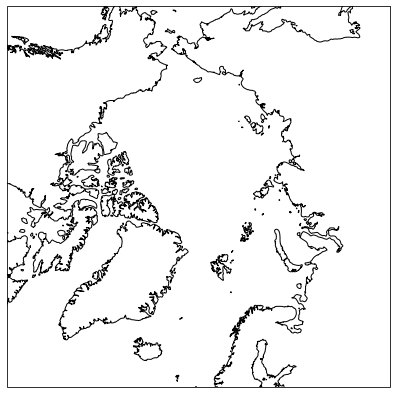

In [27]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180.,180.,60.,90.], ccrs.PlateCarree())
ax.coastlines()
ax.add_geometries([bbox_features[0]], crs=map_proj, alpha=0.3)

---

## Resources (optional)

---

## Conclusion